# EuroSAT images classification
The [EuroSAT RGB](https://github.com/phelber/EuroSAT) dataset contains 27000 patches of Sentinel-2 64x64 pixels RGB images divided in 10 classes: Pasture, HerbaceousVegetation, Industrial, AnnualCrop, Residential, PermanentCrop, Highway, SeaLake, Forest, River. 

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
import torchvision
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print("PyTorch version: %s"%torch.__version__)

NumPy version: 1.23.1
Pandas version: 1.4.3
PyTorch version: 1.13.0


We download the dataset into a local folder in order to create a training set, a validation set, and a test set. For each class we will use 70% of the images for training, 20% for validation, and 10% for test. we can see that each class contains 2500 or 3000 images so the classes are quite well balanced. 

In [3]:
import os
import pathlib

imgdir_path = pathlib.Path('../../eurosatprj/data/EuroSAT/2750')
tot = 0
file_list = []
for folder_path in imgdir_path.glob('*'):
    print(f'{folder_path}')
    count = 0
    for file_path in folder_path.glob('*'): 
        #file_name = file_path.relative_to(folder_path)
        file_list.append(str(file_path))
        count += 1
    print(count)
    tot += count
print('Total number of files: {0:d}'.format(tot))

..\..\eurosatprj\data\EuroSAT\2750\AnnualCrop
3000
..\..\eurosatprj\data\EuroSAT\2750\Forest
3000
..\..\eurosatprj\data\EuroSAT\2750\HerbaceousVegetation
3000
..\..\eurosatprj\data\EuroSAT\2750\Highway
2500
..\..\eurosatprj\data\EuroSAT\2750\Industrial
2500
..\..\eurosatprj\data\EuroSAT\2750\Pasture
2000
..\..\eurosatprj\data\EuroSAT\2750\PermanentCrop
2500
..\..\eurosatprj\data\EuroSAT\2750\Residential
3000
..\..\eurosatprj\data\EuroSAT\2750\River
2500
..\..\eurosatprj\data\EuroSAT\2750\SeaLake
3000
Total number of files: 27000


We put the file paths and the labels into two lists that will be passed to our dataset class

In [4]:
import re

file_names = [str(os.path.basename(path)) for path in file_list]
reg_ex = r'(.+)_\d+.jpg$'
labels = [re.findall(reg_ex, file_name)[0] for file_name in file_names]
eurosat_classes = np.unique(labels).tolist()
num_labels = [eurosat_classes.index(label) for label in labels]

In [5]:
file_list[6001], labels[6001], num_labels[6001]

('..\\..\\eurosatprj\\data\\EuroSAT\\2750\\HerbaceousVegetation\\HerbaceousVegetation_10.jpg',
 'HerbaceousVegetation',
 2)

We can have a look at some of the images

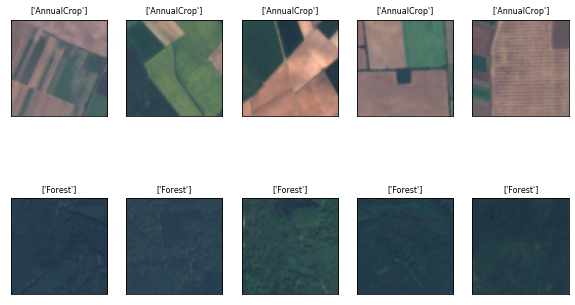

In [7]:
from itertools import islice
from PIL import Image

fig = plt.figure(figsize=(10, 6))
start = 2995
stop = 3005
for i, image in islice(enumerate(file_list), start, stop):
    ax = fig.add_subplot(2, 5, i - start + 1)
    ax.set_xticks([]); ax.set_yticks([])
    name = os.path.basename(image)
    reg_ex = r'(.+)_\d+.jpg$'
    label = re.findall(reg_ex, name)
    ax.set_title(f'{label}', size=8)
    img = Image.open(image)
    ax.imshow(img)
    


## The EuroSatDataset class
We implement the data structure for the EuroSAT dataset as a subclass of PyTorch Dataset, where we store the paths to the images on the file system and their labels.

In [8]:
from torch.utils.data import Dataset
from torchvision.io import read_image
import re

class EuroSatDataset(Dataset):
    def __init__(self, file_list, labels, transform=None, target_transform=None):
        self.labels = labels
        self.file_list = file_list
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = read_image(self.file_list[index])      
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [9]:
import torchvision.transforms as transforms 

transform = transforms.Compose([
    transforms.ToTensor(),
])

In [10]:
eurosat_dataset = EuroSatDataset(file_list, labels)

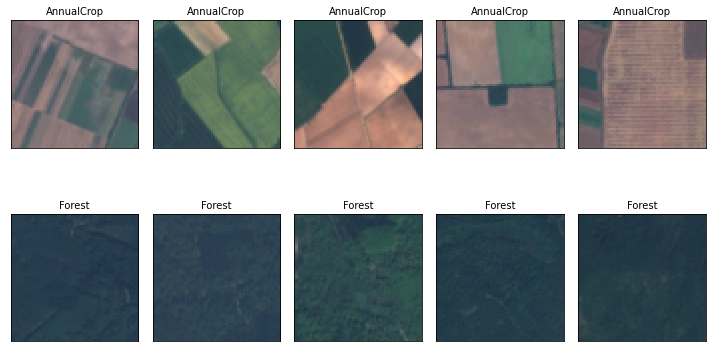

In [11]:
start = 2995
stop = 3005
fig = plt.figure(figsize=(10, 6))
for i, example in islice(enumerate(eurosat_dataset), start, stop):
    ax = fig.add_subplot(2, 5, i - start + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0].numpy().transpose((1, 2, 0)))
    ax.set_title(f'{example[1]}', size=10)
    
plt.tight_layout()
plt.show()

## The EuroSAT DataLoader
Once we have implemented the dataset to store the paths to the images and the labels, we have to carry out the following steps:  

1. Shuffle the images 
2. Split them into three subsets for training, validation, and test
3. Define the batches that will be used for training our model 

In PyTorch we can use the random_split() function to randomize and split the data 

In [30]:
from torch.utils.data import random_split

euro_train_ds, euro_val_ds, euro_test_ds = random_split(eurosat_dataset, [0.7, 0.2, 0.1], 
                                                        generator=torch.Generator().manual_seed(42))

The sum of the images in the three subsets is the same as in the original dataset.

In [33]:
len(euro_train_ds) + len(euro_val_ds) + len(euro_test_ds) 

27000

We can check that the images are randomized and the labels correspond to the image

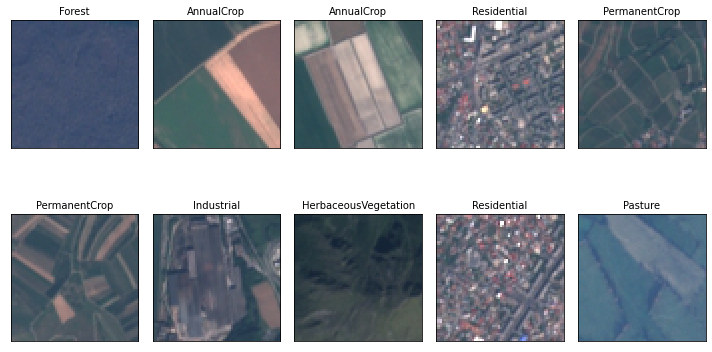

In [32]:
fig = plt.figure(figsize=(10, 6))
for i, example in enumerate(euro_train_ds):
    if i >= 10: break
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0].numpy().transpose((1, 2, 0)))
    ax.set_title(f'{example[1]}', size=10)
    
plt.tight_layout()
plt.show()

We can now create the Dataloaders for our three subsets

In [35]:
from torch.utils.data import DataLoader

torch.manual_seed(1)
eurosat_train_dl = DataLoader(dataset=euro_train_ds, batch_size=64, shuffle=False)
eurosat_val_dl = DataLoader(dataset=euro_val_ds, batch_size=64, shuffle=False)
eurosat_test_dl = DataLoader(dataset=euro_test_ds, batch_size=64, shuffle=False)

## Data augmentation

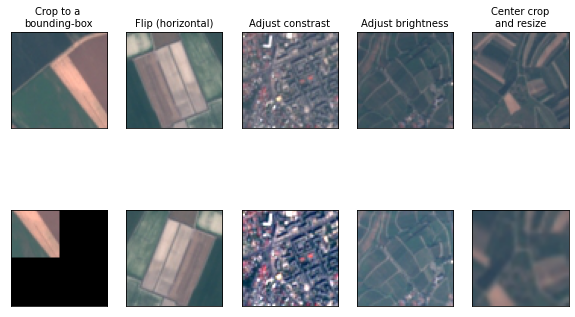

In [64]:
from torchvision import transforms 

fig = plt.figure(figsize=(10, 6))

## Column 1: cropping to a bounding-box
ax = fig.add_subplot(2, 5, 1)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img, attr = euro_train_ds[1]
ax.set_title('Crop to a \nbounding-box', size=10)
ax.imshow(img.numpy().transpose((1, 2, 0)))
ax = fig.add_subplot(2, 5, 6)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img_cropped = transforms.functional.crop(img, 32, 32, 64, 64)
ax.imshow(img_cropped.numpy().transpose((1, 2, 0)))


## Column 2: flipping (horizontally)
ax = fig.add_subplot(2, 5, 2)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img, attr = euro_train_ds[2]
ax.set_title('Flip (horizontal)', size=10)
ax.imshow(img.numpy().transpose((1, 2, 0)))
ax = fig.add_subplot(2, 5, 7)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped.numpy().transpose((1, 2, 0)))

## Column 3: adjust contrast
ax = fig.add_subplot(2, 5, 3)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img, attr = euro_train_ds[3]
ax.set_title('Adjust constrast', size=10)
ax.imshow(img.numpy().transpose((1, 2, 0)))
ax = fig.add_subplot(2, 5, 8)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img_adj_contrast = transforms.functional.adjust_contrast(img, contrast_factor=2)
ax.imshow(img_adj_contrast.numpy().transpose((1, 2, 0)))

## Column 4: adjust brightness
ax = fig.add_subplot(2, 5, 4)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img, attr = euro_train_ds[4]
ax.set_title('Adjust brightness', size=10)
ax.imshow(img.numpy().transpose((1, 2, 0)))
ax = fig.add_subplot(2, 5, 9)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img_adj_brightness = transforms.functional.adjust_brightness(img, brightness_factor=1.3)
ax.imshow(img_adj_brightness.numpy().transpose((1, 2, 0)))

## Column 5: cropping from image center 
ax = fig.add_subplot(2, 5, 5)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img, attr = euro_train_ds[5]
ax.set_title('Center crop\nand resize', size=10)
ax.imshow(img.numpy().transpose((1, 2, 0)))
ax = fig.add_subplot(2, 5, 10)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img_center_crop = transforms.functional.center_crop(img, [32, 32])
img_resized = transforms.functional.resize(img_center_crop, size=(64, 64))
ax.imshow(img_resized.numpy().transpose((1, 2, 0)))